In [1]:
import os, re
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType, NumericType


import utils.data_processing_bronze_table
import utils.data_processing_silver_table
import utils.data_processing_gold_table


ModuleNotFoundError: No module named 'utils'

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/05 11:03:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Features Attribute

In [3]:
fa = pd.read_csv('data/features_attributes.csv')
fc = pd.read_csv('data/feature_clickstream.csv')
ff = pd.read_csv('data/features_financials.csv')
features = {'fa': fa, 'fc': fc, 'ff': ff}

In [4]:
# no missing values in snapshot_date
for name, df in features.items():
    df["snapshot_date_"] = pd.to_datetime(df["snapshot_date"], format="%Y-%m-%d", errors="coerce")
    print(name, df['snapshot_date'].isna().sum())
    print(df['snapshot_date_'].min(), df['snapshot_date_'].max())
    display(df[df["snapshot_date_"].isna()])

fa 0
2023-01-01 00:00:00 2025-01-01 00:00:00


,Customer_ID,Name,Age,SSN,Occupation,snapshot_date,snapshot_date_


fc 0
2023-01-01 00:00:00 2024-12-01 00:00:00


,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date,snapshot_date_


ff 0
2023-01-01 00:00:00 2025-01-01 00:00:00


,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date,snapshot_date_


In [5]:
# set up config
snapshot_date_str = "2023-01-01"
start_date_str = "2023-01-01"
end_date_str = "2025-01-01"

# generate list of dates to process
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # List to store the first of month dates
    first_of_month_dates = []

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)

    while current_date <= end_date:
        # Append the date in yyyy-mm-dd format
        first_of_month_dates.append(current_date.strftime("%Y-%m-%d"))
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return first_of_month_dates

dates_str_lst = generate_first_of_month_dates(start_date_str, end_date_str)

In [15]:
# create bronze features datalake
bronze_dataset = {'data/features_attributes.csv': "datamart/bronze/features/features_attributes",
                   'data/feature_clickstream.csv': "datamart/bronze/features/feature_clickstream",
                     'data/features_financials.csv': "datamart/bronze/features/features_financials"}

for bronze_directory in bronze_dataset.values():
    if not os.path.exists(bronze_directory):
        os.makedirs(bronze_directory)

In [18]:
def process_bronze_table(csv_file_path, snapshot_date_str, bronze_directory, spark):
    # prepare arguments
    snapshot_date = datetime.strptime(snapshot_date_str, "%Y-%m-%d")

    df = spark.read.csv(csv_file_path, header=True, inferSchema=True).filter(col('snapshot_date') == snapshot_date)
    print(snapshot_date_str + 'row count:', df.count())

    # save bronze table to datamart - IRL connect to database to write
    partition_name = "/bronze_" + snapshot_date_str.replace('-','_') + '.csv'
    filepath = bronze_directory + partition_name
    df.toPandas().to_csv(filepath, index=False)
    print('saved to:', filepath)

    return df


In [19]:
for data_dir, bronze_directory in bronze_dataset.items():
    for snapshot_date_str in dates_str_lst:
        process_bronze_table(data_dir, snapshot_date_str, bronze_directory, spark)


2023-01-01row count: 530
saved to: datamart/bronze/features/features_attributes/bronze_2023_01_01.csv
2023-02-01row count: 501
saved to: datamart/bronze/features/features_attributes/bronze_2023_02_01.csv
2023-03-01row count: 506
saved to: datamart/bronze/features/features_attributes/bronze_2023_03_01.csv
2023-04-01row count: 510
saved to: datamart/bronze/features/features_attributes/bronze_2023_04_01.csv
2023-05-01row count: 521
saved to: datamart/bronze/features/features_attributes/bronze_2023_05_01.csv
2023-06-01row count: 517
saved to: datamart/bronze/features/features_attributes/bronze_2023_06_01.csv
2023-07-01row count: 471
saved to: datamart/bronze/features/features_attributes/bronze_2023_07_01.csv
2023-08-01row count: 481
saved to: datamart/bronze/features/features_attributes/bronze_2023_08_01.csv
2023-09-01row count: 454
saved to: datamart/bronze/features/features_attributes/bronze_2023_09_01.csv
2023-10-01row count: 487
saved to: datamart/bronze/features/features_attributes/br

# Silver

### EDA

features_attributes

In [149]:
fa = pd.read_csv('datamart/bronze/features/features_attributes/bronze_2023_06_01.csv')
fa.head(), fa.dtypes

(  Customer_ID           Name   Age          SSN    Occupation snapshot_date
 0  CUS_0x1044  Maki Shirakip    44    #F%$D@*&8       _______    2023-06-01
 1  CUS_0x104e       Kentaros    50  837-93-5062       Teacher    2023-06-01
 2  CUS_0x105c         Lopezz  4746  998-18-7252    Journalist    2023-06-01
 3  CUS_0x10ee        Hudsonb   30_  699-80-2426    Journalist    2023-06-01
 4  CUS_0x1136        Stevenk    22  894-06-9872  Entrepreneur    2023-06-01,
 Customer_ID      object
 Name             object
 Age              object
 SSN              object
 Occupation       object
 snapshot_date    object
 dtype: object)

In [150]:
pattern = r"^\d{3}-\d{2}-\d{4}$"
fa['SSN_'] = fa['SSN']
fa.loc[~fa['SSN'].str.match(pattern), "SSN_"] = "___"
fa

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date,SSN_
0,CUS_0x1044,Maki Shirakip,44,#F%$D@*&8,_______,2023-06-01,___
1,CUS_0x104e,Kentaros,50,837-93-5062,Teacher,2023-06-01,837-93-5062
2,CUS_0x105c,Lopezz,4746,998-18-7252,Journalist,2023-06-01,998-18-7252
3,CUS_0x10ee,Hudsonb,30_,699-80-2426,Journalist,2023-06-01,699-80-2426
4,CUS_0x1136,Stevenk,22,894-06-9872,Entrepreneur,2023-06-01,894-06-9872
...,...,...,...,...,...,...,...
512,CUS_0xebe,Sarah N.y,38,927-90-3768,Journalist,2023-06-01,927-90-3768
513,CUS_0xf30,Hornbyb,29,#F%$D@*&8,Journalist,2023-06-01,___
514,CUS_0xf59,Huntt,22,008-37-9819,Doctor,2023-06-01,008-37-9819
515,CUS_0xfbd,Scott Malonek,39,208-16-6908,Manager,2023-06-01,208-16-6908


Occupation,Accountant,Architect,Developer,Doctor,Engineer,Entrepreneur,Journalist,Lawyer,Manager,Mechanic,Media_Manager,Musician,Scientist,Teacher,Writer,_______
Name,30,33,35,27,27,30,33,38,32,31,40,33,30,36,21,41


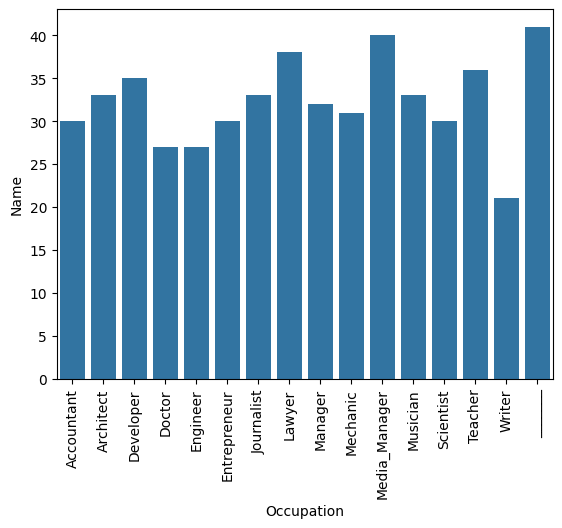

In [151]:
sns.barplot(data=fa.groupby('Occupation').count(), x='Occupation', y='Name')
plt.xticks(rotation=90)
fa.groupby('Occupation')[['Name']].count().T 

Occupation_,Accountant,Architect,Developer,Doctor,Engineer,Entrepreneur,Journalist,Lawyer,Manager,Mechanic,Media_Manager,Musician,Scientist,Teacher,Writer,___
Name,30,33,35,27,27,30,33,38,32,31,40,33,30,36,21,41


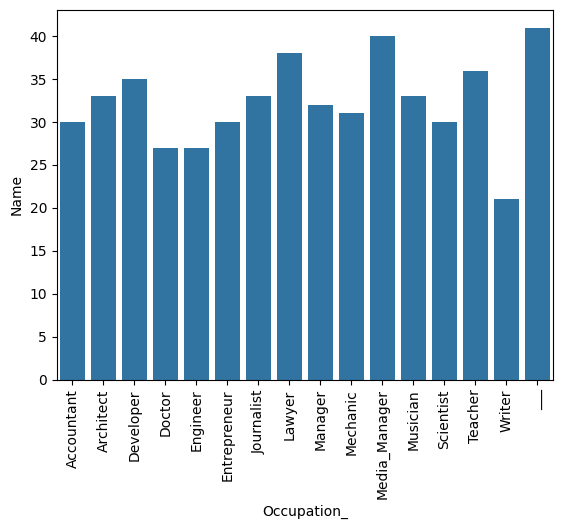

In [152]:
fa['Occupation_'] = fa['Occupation'].str.strip('_').fillna('___').replace("", "___")  # change default value to ___, incase someone put different number of _
sns.barplot(data=fa.groupby('Occupation_').count(), x='Occupation_', y='Name')
plt.xticks(rotation=90)
fa.groupby('Occupation_')[['Name']].count().T 

In [153]:
# Check for non-numeric values in 'Age' column
col_to_check = 'Age'
bad_values = fa[pd.to_numeric(fa[col_to_check], errors="coerce").isna()][col_to_check].unique()
print(bad_values)

# Strip unwanted characters and convert to numeric
fa['Age_'] = (
    fa['Age']
    .astype(str)
    .str.strip(" _")
    .astype(float)
)
fa.loc[pd.to_numeric(fa['Age_'], errors="coerce").isna()]

['30_' '18_' '42_' '38_' '37_' '44_' '28_' '17_' '24_' '19_' '32_' '29_'
 '52_' '34_' '46_' '26_' '51_' '50_' '41_' '36_' '55_']


,Customer_ID,Name,Age,SSN,Occupation,snapshot_date,SSN_,Occupation_,Age_


,Customer_ID,Name,Age,SSN,Occupation,snapshot_date,SSN_,Occupation_,Age_
2,CUS_0x105c,Lopezz,4746,998-18-7252,Journalist,2023-06-01,998-18-7252,Journalist,4746.0
12,CUS_0x145c,Lewis Krauskopfu,5959,448-30-5081,Writer,2023-06-01,448-30-5081,Writer,5959.0
44,CUS_0x1de3,Leskep,2318,541-79-1548,Lawyer,2023-06-01,541-79-1548,Lawyer,2318.0
100,CUS_0x344a,Philip Blenkinsopw,6280,869-92-2559,Teacher,2023-06-01,869-92-2559,Teacher,6280.0
129,CUS_0x40c8,Deepa Seetharamanm,-500,264-82-1553,Media_Manager,2023-06-01,264-82-1553,Media_Manager,-500.0
170,CUS_0x52b7,Supantha Mukherjeeo,-500,090-51-5624,Accountant,2023-06-01,090-51-5624,Accountant,-500.0
183,CUS_0x5c2,Shalal-Esak,5645,554-33-7055,Developer,2023-06-01,554-33-7055,Developer,5645.0
219,CUS_0x6902,Alexei Oreskovich,4351,845-47-0164,Writer,2023-06-01,845-47-0164,Writer,4351.0
288,CUS_0x7e24,Kellyx,6728,298-06-5346,Media_Manager,2023-06-01,298-06-5346,Media_Manager,6728.0
324,CUS_0x8b0c,Ronald Groverk,4909,587-03-6623,Lawyer,2023-06-01,587-03-6623,Lawyer,4909.0


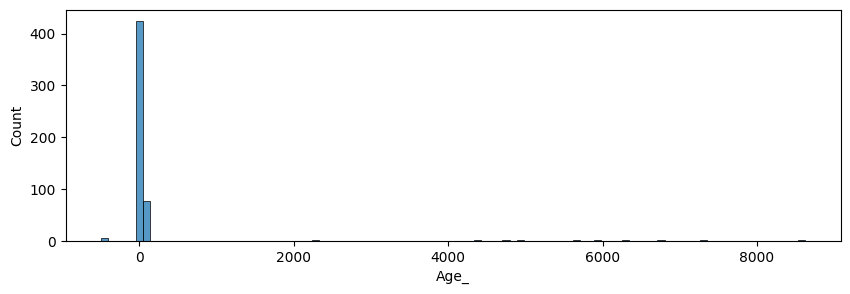

In [154]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.histplot(fa, x='Age_', bins=100, ax=ax)
fa[(fa['Age_'] > 100 )|( fa['Age_'] <0 )]

<Axes: xlabel='Age_', ylabel='Count'>

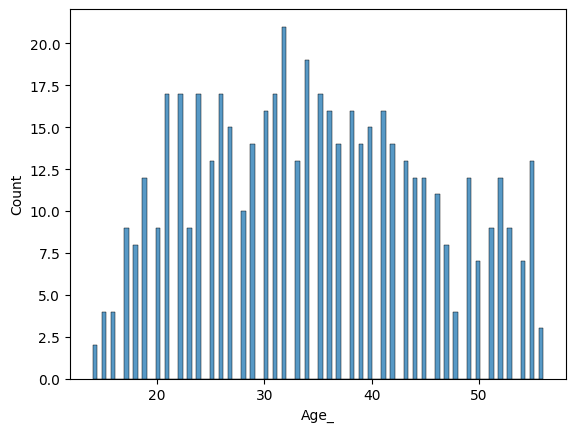

In [171]:
# avg age by occupation without outliers
avg_age_by_occupation = fa[fa['Age_'].between(0, 100)].groupby('Occupation_').agg({'Age_': 'mean'}).reset_index()
# replace outlier age with age from the average by occupation
fa = fa.merge(avg_age_by_occupation, on='Occupation_', how='left', suffixes=('', '_avg'))
fa['Age_'] = np.where(fa['Age_'].between(0, 100), fa['Age_'], fa['Age__avg'])
fa['Age_'] = fa['Age_'].round(0).astype(int)
fa = fa.drop(columns=['Age__avg'])
sns.histplot(fa, x='Age_', bins=100)


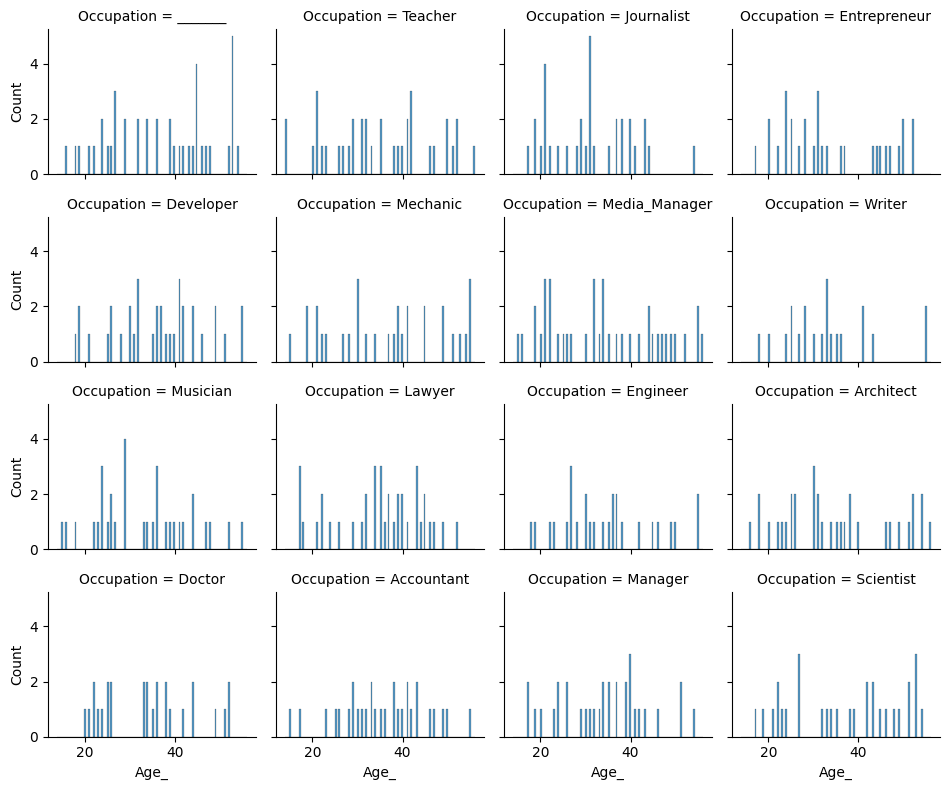

In [172]:
# create on subplot for each occupation
sns.displot(
    data=fa,
    x="Age_",
    bins=100,
    col="Occupation",       # one subplot per occupation
    col_wrap=4,             # wrap after 4 plots per row
    height=2, aspect=1.2,   # control subplot size
)

In [173]:
fa['snapshot_date'] = pd.to_datetime(fa['snapshot_date'], format="%Y-%m-%d", errors="coerce")
fa['snapshot_date'].isna().sum()

np.int64(0)

In [175]:
print(fa.dtypes)
display(fa.head())

Customer_ID              object
Name                     object
Age                      object
SSN                      object
Occupation               object
snapshot_date    datetime64[ns]
SSN_                     object
Occupation_              object
Age_                      int64
dtype: object


,Customer_ID,Name,Age,SSN,Occupation,snapshot_date,SSN_,Occupation_,Age_
0,CUS_0x1044,Maki Shirakip,44,#F%$D@*&8,_______,2023-06-01,___,___,44
1,CUS_0x104e,Kentaros,50,837-93-5062,Teacher,2023-06-01,837-93-5062,Teacher,50
2,CUS_0x105c,Lopezz,4746,998-18-7252,Journalist,2023-06-01,998-18-7252,Journalist,31
3,CUS_0x10ee,Hudsonb,30_,699-80-2426,Journalist,2023-06-01,699-80-2426,Journalist,30
4,CUS_0x1136,Stevenk,22,894-06-9872,Entrepreneur,2023-06-01,894-06-9872,Entrepreneur,22


### features attribute silver table processing

In [192]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F
import argparse

from pyspark.sql.functions import col, when, trim, regexp_replace, avg, round as spark_round
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType


In [193]:
filepath = 'datamart/bronze/features/features_attributes/bronze_2023_01_01.csv'
###################
fa = spark.read.csv(filepath, header=True, inferSchema=True)
print('loaded from:', filepath, 'row count:', fa.count())

# clean data: enforce schema / data type
# Dictionary specifying columns and their desired datatypes
column_type_map = {
    "Customer_ID": StringType(),
    "Name": StringType(),
    "Age": IntegerType(),
    "SSN": StringType(),
    "Occupation": StringType(),
    "snapshot_date": DateType(),
}

# enfore datatype
for column, new_type in column_type_map.items():
    fa = fa.withColumn(column, col(column).cast(new_type))

# SSN processing
pattern = r'^\d{3}-\d{2}-\d{4}$'
fa = fa.withColumn(
    "SSN_",
    when(col("SSN").rlike(pattern), col("SSN")).otherwise("___")
)

# Occupation processing
fa = fa.withColumn(
    "Occupation_",
    when(
        # after cleaning, if null or empty → set to "___"
        (col("Occupation").isNull()) | 
        (trim(regexp_replace(col("Occupation"), r"^_+|_+$", "")) == ""),
        "___"
    ).otherwise(
        # else keep the cleaned value
        trim(regexp_replace(col("Occupation"), r"^_+|_+$", ""))
    )
)

# Age processing
# 1. Clean Age: strip spaces/underscores, cast to float
fa = fa.withColumn(
    "Age_",
    regexp_replace(trim(col("Age")), r"^_+|_+$", "").cast("float")
)

# 2. Compute average Age_ per Occupation_, filtering valid ages only
avg_age_by_occ = (
    fa
    .filter((col("Age_") >= 0) & (col("Age_") <= 100))
    .groupBy("Occupation_")
    .agg(avg("Age_").alias("Age__avg"))
)

# 3. Join back to main dataframe
fa = fa.join(avg_age_by_occ, on="Occupation_", how="left")

# 4. Replace outlier ages with group average
fa = fa.withColumn(
    "Age_",
    when((col("Age_") >= 0) & (col("Age_") <= 100), col("Age_"))
    .otherwise(col("Age__avg"))
)

# 5. Round to integer
fa = fa.withColumn("Age_", spark_round(col("Age_")).cast("int"))

# 6. Drop helper column
fa = fa.drop("Age__avg")


loaded from: datamart/bronze/features/features_attributes/bronze_2023_01_01.csv row count: 530


### features_clickstream

In [200]:
fc = pd.read_csv('datamart/bronze/features/feature_clickstream/bronze_2023_06_01.csv')
display(fc.head()), fc.dtypes

,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,145,108,78,-33,212,62,-46,135,-6,96,...,-82,79,-72,184,114,281,-45,51,CUS_0x1037,2023-06-01
1,14,155,70,45,233,-121,174,159,3,154,...,119,275,116,166,154,81,75,163,CUS_0x1069,2023-06-01
2,305,197,101,-41,-30,60,266,66,110,-65,...,67,103,-3,309,233,149,185,68,CUS_0x114a,2023-06-01
3,3,186,311,8,-105,124,62,89,160,70,...,185,62,135,104,66,1,152,200,CUS_0x1184,2023-06-01
4,311,241,25,29,133,247,-11,-20,-95,196,...,159,232,105,276,-53,131,153,-46,CUS_0x1297,2023-06-01


(None,
 fe_1              int64
 fe_2              int64
 fe_3              int64
 fe_4              int64
 fe_5              int64
 fe_6              int64
 fe_7              int64
 fe_8              int64
 fe_9              int64
 fe_10             int64
 fe_11             int64
 fe_12             int64
 fe_13             int64
 fe_14             int64
 fe_15             int64
 fe_16             int64
 fe_17             int64
 fe_18             int64
 fe_19             int64
 fe_20             int64
 Customer_ID      object
 snapshot_date    object
 dtype: object)

In [ ]:
# check for nans and min/max for each feature column
# if any missing values, impute with mean
fe_cols = [x for x in fc.columns if x[:2] == 'fe']
for col in fe_cols:
    fc[col] = pd.to_numeric(fc[col], errors='coerce')
    print(col, fc[col].isna().sum())
    print(fc[col].min(), fc[col].max())
    fc[col] = fc[col].fillna(fc[col].mean())

fe_1 0
-304 435
fe_2 0
-286 523
fe_3 0
-289 483
fe_4 0
-275 517
fe_5 0
-327 523
fe_6 0
-247 488
fe_7 0
-270 503
fe_8 0
-264 488
fe_9 0
-296 513
fe_10 0
-237 478
fe_11 0
-301 502
fe_12 0
-253 479
fe_13 0
-275 487
fe_14 0
-283 476
fe_15 0
-300 508
fe_16 0
-281 514
fe_17 0
-291 473
fe_18 0
-324 499
fe_19 0
-310 520
fe_20 0
-277 481


In [207]:
from pyspark.sql.functions import mean as spark_mean, col

# load CSV
fc_spark = spark.read.csv(
    "datamart/bronze/features/feature_clickstream/bronze_2023_06_01.csv",
    header=True,
    inferSchema=True
)

# get list of feature columns
fe_cols = [c for c in fc_spark.columns if c.startswith("fe")]

# 1. Compute means for all feature columns at once
mean_exprs = [ spark_mean(col(c)).alias(c) for c in fe_cols ]
mean_row = fc_spark.select(*mean_exprs).collect()[0].asDict()

# 2. Fill NaN/Null values with column means
fc_spark = fc_spark.fillna(mean_row)

### features_financials

In [4]:
ff = pd.read_csv('datamart/bronze/features/features_financials/bronze_2023_06_01.csv')
display(ff.head().T), ff.dtypes

,0,1,2,3,4
Customer_ID,CUS_0x1044,CUS_0x104e,CUS_0x105c,CUS_0x10ee,CUS_0x1136
Annual_Income,33441.59,19180.87,127617.6,12660.16,37360.94
Monthly_Inhand_Salary,2748.799167,1688.405833,10596.8,909.013333,2864.411667
Num_Bank_Accounts,2,8,0,5,10
Num_Credit_Card,4,4,4,7,5
Interest_Rate,1,18,5,15,33
Num_of_Loan,0,4,3,0,5
Type_of_Loan,NaN,"Debt Consolidation Loan, Auto Loan, Payday Loa...","Not Specified, Mortgage Loan, and Payday Loan",NaN,"Home Equity Loan, Auto Loan, Debt Consolidatio..."
Delay_from_due_date,1,5,3,8,44
Num_of_Delayed_Payment,4,17,6,14,12


(None,
 Customer_ID                  object
 Annual_Income                object
 Monthly_Inhand_Salary       float64
 Num_Bank_Accounts             int64
 Num_Credit_Card               int64
 Interest_Rate                 int64
 Num_of_Loan                  object
 Type_of_Loan                 object
 Delay_from_due_date           int64
 Num_of_Delayed_Payment       object
 Changed_Credit_Limit         object
 Num_Credit_Inquiries        float64
 Credit_Mix                   object
 Outstanding_Debt             object
 Credit_Utilization_Ratio    float64
 Credit_History_Age           object
 Payment_of_Min_Amount        object
 Total_EMI_per_month         float64
 Amount_invested_monthly      object
 Payment_Behaviour            object
 Monthly_Balance             float64
 snapshot_date                object
 dtype: object)

In [5]:
ff.dtypes.to_dict()

{'Customer_ID': dtype('O'),
 'Annual_Income': dtype('O'),
 'Monthly_Inhand_Salary': dtype('float64'),
 'Num_Bank_Accounts': dtype('int64'),
 'Num_Credit_Card': dtype('int64'),
 'Interest_Rate': dtype('int64'),
 'Num_of_Loan': dtype('O'),
 'Type_of_Loan': dtype('O'),
 'Delay_from_due_date': dtype('int64'),
 'Num_of_Delayed_Payment': dtype('O'),
 'Changed_Credit_Limit': dtype('O'),
 'Num_Credit_Inquiries': dtype('float64'),
 'Credit_Mix': dtype('O'),
 'Outstanding_Debt': dtype('O'),
 'Credit_Utilization_Ratio': dtype('float64'),
 'Credit_History_Age': dtype('O'),
 'Payment_of_Min_Amount': dtype('O'),
 'Total_EMI_per_month': dtype('float64'),
 'Amount_invested_monthly': dtype('O'),
 'Payment_Behaviour': dtype('O'),
 'Monthly_Balance': dtype('float64'),
 'snapshot_date': dtype('O')}

In [6]:
ff = pd.read_csv('datamart/bronze/features/features_financials/bronze_2023_06_01.csv')
cols = {'Customer_ID': np.dtype('O'),
 'Annual_Income': np.dtype('O'),
 'Monthly_Inhand_Salary': np.dtype('float64'),
 'Num_Bank_Accounts': np.dtype('int64'),
 'Num_Credit_Card': np.dtype('int64'),
 'Interest_Rate': np.dtype('int64'),
 'Num_of_Loan': np.dtype('O'),
 'Type_of_Loan': np.dtype('O'),
 'Delay_from_due_date': np.dtype('int64'),
 'Num_of_Delayed_Payment': np.dtype('O'),
 'Changed_Credit_Limit': np.dtype('O'),
 'Num_Credit_Inquiries': np.dtype('float64'),
 'Credit_Mix': np.dtype('O'),
 'Outstanding_Debt': np.dtype('O'),
 'Credit_Utilization_Ratio': np.dtype('float64'),
 'Credit_History_Age': np.dtype('O'),
 'Payment_of_Min_Amount': np.dtype('O'),
 'Total_EMI_per_month': np.dtype('float64'),
 'Amount_invested_monthly': np.dtype('O'),
 'Payment_Behaviour': np.dtype('O'),
 'Monthly_Balance': np.dtype('O'),
 'snapshot_date': np.dtype('O')}

for col, col_type in cols.items():
    bad_values = ff.loc[pd.to_numeric(ff[col], errors='coerce').astype('float').isna(), col].unique()
    print("\n\n",col, bad_values)



 Customer_ID ['CUS_0x1044' 'CUS_0x104e' 'CUS_0x105c' 'CUS_0x10ee' 'CUS_0x1136'
 'CUS_0x1154' 'CUS_0x1156' 'CUS_0x119e' 'CUS_0x128e' 'CUS_0x1319'
 'CUS_0x1329' 'CUS_0x142f' 'CUS_0x145c' 'CUS_0x149e' 'CUS_0x14ca'
 'CUS_0x157a' 'CUS_0x1585' 'CUS_0x1664' 'CUS_0x166c' 'CUS_0x1698'
 'CUS_0x16a2' 'CUS_0x16d9' 'CUS_0x1766' 'CUS_0x17e0' 'CUS_0x17ef'
 'CUS_0x17fe' 'CUS_0x1810' 'CUS_0x18c5' 'CUS_0x18c6' 'CUS_0x1972'
 'CUS_0x199a' 'CUS_0x1a2a' 'CUS_0x1a2f' 'CUS_0x1a4a' 'CUS_0x1aa4'
 'CUS_0x1aee' 'CUS_0x1bbb' 'CUS_0x1c1a' 'CUS_0x1c99' 'CUS_0x1ca9'
 'CUS_0x1cdb' 'CUS_0x1d6f' 'CUS_0x1db0' 'CUS_0x1dc2' 'CUS_0x1de3'
 'CUS_0x1e52' 'CUS_0x1e70' 'CUS_0x1e91' 'CUS_0x1e95' 'CUS_0x1ec4'
 'CUS_0x1f96' 'CUS_0x2224' 'CUS_0x224f' 'CUS_0x225e' 'CUS_0x22f4'
 'CUS_0x2301' 'CUS_0x2312' 'CUS_0x23a6' 'CUS_0x23b0' 'CUS_0x242b'
 'CUS_0x245d' 'CUS_0x2479' 'CUS_0x250b' 'CUS_0x25a4' 'CUS_0x25a5'
 'CUS_0x25ae' 'CUS_0x2611' 'CUS_0x2617' 'CUS_0x2618' 'CUS_0x26d7'
 'CUS_0x26ea' 'CUS_0x275c' 'CUS_0x2794' 'CUS_0x27a4' 'CUS_0x2

In [22]:
pdf.head()

,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date,is_invalid_income
0,CUS_0x1000,30625.939453,2706.161667,6,5,27,2,"Credit-Builder Loan, and Home Equity Loan",57,26,...,1562.91,30.077191,10 Years and 9 Months,Yes,42.941090,77.31427572208112,High_spent_Medium_value_payments,400.36080052211616,2023-05-01,0
1,CUS_0x1009,52312.679688,4250.390000,6,5,17,4,"Not Specified, Home Equity Loan, Credit-Builde...",5,18,...,202.68,40.286997,31 Years and 0 Months,Yes,108.366467,58.66019164829086,High_spent_Medium_value_payments,508.01234122645366,2025-01-01,0
2,CUS_0x100b,113781.390625,9549.782500,1,4,1,0,None,14,8,...,1030.2,28.592943,15 Years and 10 Months,No,0.000000,617.0792665202719,High_spent_Small_value_payments,597.8989834797281,2024-03-01,0
3,CUS_0x1011,58918.468750,5208.872500,3,3,17,3,"Student Loan, Credit-Builder Loan, and Debt Co...",27,13,...,473.14,27.829959,15 Years and 10 Months,Yes,123.434939,383.35084463651407,Low_spent_Medium_value_payments,294.1014665671429,2023-11-01,0
4,CUS_0x1013,98620.976562,7962.415000,3,3,6,3,"Student Loan, Debt Consolidation Loan, and Per...",12,9,...,1233.51,26.524864,17 Years and 10 Months,No,228.018084,332.3337079767732,High_spent_Medium_value_payments,485.8897083704929,2023-12-01,0


In [49]:
# load CSV
df = spark.read.csv(
    "data/features_financials.csv",
    header=True,
    inferSchema=True
)

def ff_col_to_clean(df, col_name, dtype):
    # Step 1: remove invalid chars (anything not digit or dot)
    df = df.withColumn(col_name, F.regexp_replace(col_name, "[^0-9.]", ""))

    # Step 2: cast to float — invalid will become null
    df = df.withColumn(col_name, F.col(col_name).cast(dtype))

    # Step 3: Set min annual income to be 0
    df = df.withColumn(
        col_name,
        F.when(F.col(col_name) < 0, 0)
        .otherwise(F.col(col_name))
    )
    return df

df = ff_col_to_clean(df, "Annual_Income", "float")
df = ff_col_to_clean(df, "Monthly_Inhand_Salary", "float")
df = ff_col_to_clean(df, "Num_Bank_Accounts", "int")
df = ff_col_to_clean(df, "Num_Credit_Card", "int")
df = ff_col_to_clean(df, "Interest_Rate", "float")
df = ff_col_to_clean(df, "Num_of_Loan", "int")
df = ff_col_to_clean(df, "Delay_from_due_date", "int")
df = ff_col_to_clean(df, "Num_of_Delayed_Payment", "int")
df = ff_col_to_clean(df, "Changed_Credit_Limit", "float")
df = ff_col_to_clean(df, "Outstanding_Debt", "float")
df = ff_col_to_clean(df, "Credit_Utilization_Ratio", "float")
df = ff_col_to_clean(df, "Total_EMI_per_month", "float")
df = ff_col_to_clean(df, "Amount_invested_monthly", "float")
df = ff_col_to_clean(df, "Monthly_Balance", "float")

### convert credit history age
# Step 1: Extract numeric parts using regex
df = df.withColumn("Years",  F.regexp_extract(F.col("Credit_History_Age"), r'(\d+)\s+Years', 1))
df = df.withColumn("Months", F.regexp_extract(F.col("Credit_History_Age"), r'(\d+)\s+Months', 1))
# Step 2: Convert to integer (handle nulls / blanks)
df = df.withColumn("Years",  F.when(F.col("Years") == "", 0).otherwise(F.col("Years").cast("int")))
df = df.withColumn("Months", F.when(F.col("Months") == "", 0).otherwise(F.col("Months").cast("int")))
# Step 3: Compute total months
df = df.withColumn("Credit_History_Months", (F.col("Years") * 12 + F.col("Months")).cast("int"))
# Step 4: Drop intermediate columns
df = df.drop("Years", "Months")

### convert payment behaviour
# Step 1 Define the column
col = "Payment_Behaviour"

# Step 2 Extract 'spend' and 'value' parts using regex
df = (
    df.withColumn("Spend_Level",
        F.when(F.col(col).rlike("(?i)low_spent"), 1)
         .when(F.col(col).rlike("(?i)medium_spent"), 2)
         .when(F.col(col).rlike("(?i)high_spent"), 3)
         .otherwise(0)
    )
    .withColumn("Value_Level",
        F.when(F.col(col).rlike("(?i)small_value"), 1)
         .when(F.col(col).rlike("(?i)medium_value"), 2)
         .when(F.col(col).rlike("(?i)large_value"), 3)
         .otherwise(0)
    )
    .withColumn(
        "Credit_Mix",
        F.when((F.col("Credit_Mix").isin("_", "", "NA", "NaN")) | F.col("Credit_Mix").isNull(), "Unknown")
         .otherwise(F.initcap(F.col("Credit_Mix")))  # ensures "standard" → "Standard"
    )
    .withColumn(
        "Payment_of_Min_Amount",
        F.when(F.col("Payment_of_Min_Amount") == "Yes", "Yes")
         .when(F.col("Payment_of_Min_Amount") == "No", "No")
         .when(F.col("Payment_of_Min_Amount") == "NM", "Unknown")  # handle special case
         .otherwise("Unknown")
    )
)

### loan types
# all_loan_types extracted once from full feature financial data
all_loan_types = ['Auto Loan',
 'Credit-Builder Loan',
 'Debt Consolidation Loan',
 'Home Equity Loan',
 'Mortgage Loan',
 'Payday Loan',
 'Personal Loan',
 'Student Loan']

df = df.withColumn(
    "loan_list",
    F.split(F.regexp_replace(F.col("Type_of_Loan"), "and", ","), ",")
)
df = df.withColumn(
    "loan_list",
    F.expr("filter(transform(loan_list, x -> trim(x)), x -> x != '' and x != 'Not Specified')")
)

for loan in all_loan_types:
    df = df.withColumn(
        loan,
        F.when(F.array_contains(F.col("loan_list"), loan), F.lit(1)).otherwise(F.lit(0))
    )


# sum across all loan columns
df = df.withColumn("sum_loans", sum(F.col(c) for c in all_loan_types))

# unseen = 1 if none of the known loan types are marked (sum == 0)
df = df.withColumn("unseen", F.when(F.col("sum_loans") == 0, 1).otherwise(0))

# optionally drop helper column
df = df.drop("sum_loans")
df = df.drop("loan_list")


### snapshot date
# Step 1 Normalize common separators
df = df.withColumn(
    "snapshot_date_str",
    F.regexp_replace(F.col("snapshot_date"), "[./]", "-")
)

# Step 2 Try multiple date formats
df = df.withColumn(
    "snapshot_date",
    F.coalesce(
        F.to_date("snapshot_date_str", "yyyy-MM-dd"),
        F.to_date("snapshot_date_str", "dd-MM-yyyy"),
        F.to_date("snapshot_date_str", "MM-dd-yyyy"),
        F.to_date("snapshot_date_str", "yyyy/MM/dd")
    )
)

df.show(truncate=False)

+-----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------------------------------------------------------------------------------------------------------------------------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+----------------------+---------------------+-------------------+-----------------------+--------------------------------+---------------+-------------+---------------------+-----------+-----------+---------+-------------------+-----------------------+----------------+-------------+-----------+-------------+------------+------+-----------------+
|Customer_ID|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Type_of_Loan                                                                                                                              |Delay_from_due_dat

In [36]:
def clean_loan_list(val):
    if pd.isna(val):
        return []
    # unify delimiters
    val = re.sub(r'\band\b', ',', val)
    # split on commas
    items = [x.strip() for x in val.split(',')]
    # remove empty strings, deduplicate
    items = list({x for x in items if x and x.lower() != 'not specified'})
    return items

pdf = df.toPandas()
loan_types = pdf['Type_of_Loan'].apply(clean_loan_list)
all_loan_types = sorted({loan for sublist in loan_types for loan in sublist})

In [39]:
all_loan_types

['Auto Loan',
 'Credit-Builder Loan',
 'Debt Consolidation Loan',
 'Home Equity Loan',
 'Mortgage Loan',
 'Payday Loan',
 'Personal Loan',
 'Student Loan']

# Gold Data

In [ ]:
fc = spark.read.parquet('datamart/silver/feature_clickstream/silver_FC_2023_01_01.parquet')
fa = spark.read.parquet('datamart/silver/feature_attribute/silver_FA_2023_01_01.parquet')
ff = spark.read.parquet('datamart/silver/feature_financials/silver_FF_2023_01_01.parquet') 

df = (fa
    .join(ff, on=["Customer_ID", "snapshot_date"], how="inner")
    .join(fc, on=["Customer_ID", "snapshot_date"], how="inner")
    )

# all_loan_types extracted once from full feature financial data
all_loan_types = ['Auto Loan',
 'Credit-Builder Loan',
 'Debt Consolidation Loan',
 'Home Equity Loan',
 'Mortgage Loan',
 'Payday Loan',
 'Personal Loan',
 'Student Loan',
 'unseen']

# financial multipliers
# FF
df = df.withColumn("Debt_to_Income_Ratio", F.col("Outstanding_Debt") / F.col("Annual_Income"))
df = df.withColumn("Delayed_Payment_Rate", F.col("Num_of_Delayed_Payment") / F.col("Num_of_Loan"))
df = df.withColumn("EMI_to_Income_Ratio", F.col("Total_EMI_per_month") / F.col("Monthly_Inhand_Salary"))
df = df.withColumn("Investment_Rate", F.col("Amount_invested_monthly") / F.col("Monthly_Inhand_Salary"))
df = df.withColumn("Delayed_Payment_Rate", F.col("Num_of_Delayed_Payment") / F.col("Num_of_Loan"))
df = df.withColumn("Loan_Diversity_Score", sum(F.col(c) for c in all_loan_types))

# FC
click_cols = [c for c in df.columns if c.startswith("fe_")]
df = df.withColumn("Click_Total", sum(F.col(c) for c in click_cols))
df = df.withColumn("Click_Mean", F.lit(1.0 / len(click_cols)) * sum(F.col(c) for c in click_cols))
df = df.withColumn(
    "Click_Variance",
    sum((F.col(c) - F.col("Click_Mean"))**2 for c in click_cols) / F.lit(len(click_cols))
)

# cross features
df = df.withColumn("Debt_to_Click_Ratio", F.col("Outstanding_Debt") / (F.col("Click_Total") + F.lit(1)))
df = df.withColumn("Income_to_Utilization", F.col("Annual_Income") / (F.col("Credit_Utilization_Ratio") + F.lit(1)))
df = df.withColumn("Investment_to_Clicks", F.col("Amount_invested_monthly") / (F.col("Click_Total") + F.lit(1)))
df = df.withColumn("Age_to_Credit_Age_Ratio", F.col("Credit_History_Months") / (F.col("Age") * 12))
df = df.withColumn("EMI_to_Debt_Ratio", F.col("Total_EMI_per_month") / (F.col("Outstanding_Debt") + F.lit(1)))
df = df.withColumn("Debt_to_Salary_Interaction", F.col("Outstanding_Debt") / (F.col("Monthly_Inhand_Salary") + F.lit(1)))
df = df.withColumn("Debt_Interest_Product", F.col("Outstanding_Debt") * F.col("Interest_Rate"))

# non-linear transformations
df = df.withColumn("Log_Debt", F.log1p(F.col("Outstanding_Debt")))
df = df.withColumn("Log_Income", F.log1p(F.col("Annual_Income")))
df = df.withColumn("Credit_Utilization_Sq", F.col("Credit_Utilization_Ratio")**2)
df = df.withColumn("Credit_Utilization_Cube", F.col("Credit_Utilization_Ratio")**3)

# threshold indicator variables (for linear regression)
df = df.withColumn("High_Risk_Flag", F.when(F.col("Debt_to_Income_Ratio") > 0.8, 1).otherwise(0))
df = df.withColumn("High_Interest_Flag", F.when(F.col("Interest_Rate") > 25, 1).otherwise(0))
df = df.withColumn("Has_Multiple_Loans", F.when(F.col("Num_of_Loan") > 2, 1).otherwise(0))
df = df.withColumn("Age_Bucket",
    F.when(F.col("Age") < 25, 0)
        .when(F.col("Age") < 40, 1)
        .when(F.col("Age") < 55, 2)
        .otherwise(3))
df = df.withColumn("Debt_to_Income_Bin", F.when(F.col("Debt_to_Income_Ratio") < 0.3, 0)
                                               .when(F.col("Debt_to_Income_Ratio") < 0.7, 1)
                                               .when(F.col("Debt_to_Income_Ratio") < 1.0, 2)
                                               .otherwise(3))
df = df.withColumn("Min_Payment_Flag",
                   F.when(F.col("Payment_of_Min_Amount") == "Yes", 1)
                    .when(F.col("Payment_of_Min_Amount") == "No", 0)
                    .otherwise(-1))
df = df.withColumn(
    "PMET_Job_Indicator",
    F.when(F.col("Occupation_").isin(["Engineer", "Manager", "Analyst", 'Lawyer', 'Scientist', 'Doctor', 'Accountant', 'Developer', 'Architect']), 1).otherwise(0)
)
df = df.withColumn("Is_Year_End", F.when(F.month("snapshot_date") == 12, 1).otherwise(0))

numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

for c in numeric_cols:
    df = df.withColumn(
        c,
        F.when(F.isnan(F.col(c)) | F.col(c).isNull(), 0).otherwise(F.col(c))
    )

df.show()

+-----------+-------------+-------------+------------------+---+-----------+-------------+-----------+----+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+---------------+---------------------+-----------+-----------+---------+-------------------+-----------------------+----------------+-------------+-----------+-------------+------------+------+-----------------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+------------------+------------------+--------------------+---------------------+----------

In [69]:
df = spark.read.parquet('datamart/gold/feature_store/gold_feature_store_2023_03_01.parquet').toPandas().to_csv('./test.csv')